<a href="https://colab.research.google.com/github/rakesh4real/competitive-ml/blob/main/kfold_cross_vaildation_winequality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 84199  100 84199    0     0   152k      0 --:--:-- --:--:-- --:--:--  151k


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
CSV_PATH = '/content/winequality-red.csv'

df = pd.read_csv(CSV_PATH, sep=';')

In [10]:
df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


In [12]:
df['quality'].value_counts() # target

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [14]:
quality_mapping = { 3: 0,
    4: 1,
    5: 2,
    6: 3,
    7: 4,
    8: 5
}

In [15]:
df['quality'] = df['quality'].apply(lambda x: quality_mapping[x])

# alternatively:
# ==============
# you can use the map function of pandas with
# any dictionary to convert the values in a given
# column to values in the dictionary
# df.loc[:, "quality"] = df.quality.map(quality_mapping)

In [16]:
df['quality'].value_counts()

2    681
3    638
4    199
1     53
5     18
0     10
Name: quality, dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [28]:
"""
train-test-split (not good)
"""

# shuffling the dataframe
df = df.sample(frac=1).reset_index(drop=True)

ratio = 0.65
split_idx = len(df)*ratio
df_train = df.loc[:split_idx]
df_test = df.loc[split_idx:]

In [41]:
"""
problem: classification
model: decision tree
"""

from sklearn import tree
from sklearn import metrics

# greater >> overfitting
MAX_DEPTH=3

clf = tree.DecisionTreeClassifier(max_depth=MAX_DEPTH) # other hyperparams default values

In [42]:
# Note: deccision tree does not need col - normalisation

TARGET_COL_NAME = 'quality'
X_COLS = [i for i in df.columns if i != TARGET_COL_NAME]

clf.fit(df_train[X_COLS], df_train.quality)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [51]:
"""
evaluate
"""

# train acc
train_predictions = clf.predict(df_train[X_COLS])
acc = np.mean(train_predictions == df_train.quality)
print(f'train acc: {acc*100:.2f}%')

# test acc (unseen data)
test_predictions = clf.predict(df_test[X_COLS])
acc = np.mean(test_predictions == df_test.quality)
print(f'test acc: {acc*100:.2f}%')

train acc: 57.79%
test acc: 55.99%


In [60]:
"""
cross-validate `depth`
"""

def train_tree(MAX_DEPTH):
  clf = tree.DecisionTreeClassifier(max_depth=MAX_DEPTH) # other hyperparams default values
  clf.fit(df_train[X_COLS], df_train.quality)
            
  # train acc
  train_predictions = clf.predict(df_train[X_COLS])
  acc = np.mean(train_predictions == df_train.quality)
  print(f'train acc: {acc*100:.2f}%')

  # test acc (unseen data)
  test_predictions = clf.predict(df_test[X_COLS])
  acc = np.mean(test_predictions == df_test.quality)
  print(f'test acc: {acc*100:.2f}%')

In [64]:
for depth in range(1, 20, 3):
  print("="*60)
  train_tree(MAX_DEPTH=depth)

train acc: 55.38%
test acc: 55.28%
train acc: 62.12%
test acc: 53.31%
train acc: 75.48%
test acc: 59.57%
train acc: 87.21%
test acc: 57.96%
train acc: 94.62%
test acc: 56.89%
train acc: 99.04%
test acc: 57.78%
train acc: 99.90%
test acc: 57.25%


In [66]:
# but the test acc is low (overfitting)
# use cross validation to chose best `depth`

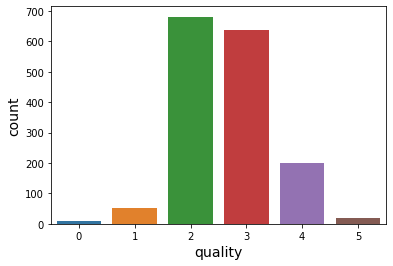

In [79]:
"""
to use stratified kfold?
"""

b = sns.countplot(x='quality', data=df)

b.set_xlabel("quality", fontsize=14)
b.set_ylabel("count", fontsize=14)
plt.show()

# yes, use stratified!!

In [95]:
"""
+ train-val-test split (good)
+ [classification] normal and stratified kfold cv
"""

from sklearn import model_selection

def do_strat_kfold(n_splits=10):
  """
  can do with images and other data to.
  just store file names

  use `stratified k-fold` if imbalanced
  (same code but targes must be mentioned)
  choose stratified k-fold blindly 😎
  """

  # load train data and instantiate kfold 
  df = df_train.loc[:]

  y = df.quality.values # for stratified
  kf = model_selection.StratifiedKFold(n_splits=n_splits) # for stratified
  #kf = model_selection.KFold(n_splits=n_splits) # normal k-fold

  # new column `kfold` with all dummy `-1` and then shuffle
  df["kfold"] = -1
  df = df.sample(frac=1).reset_index(drop=True)
  
  # fill the new column
  #for fold, (trn_, val_) in enumerate(kf.split(X=df)): # normal k-fold
  for fold, (trn_, val_) in enumerate(kf.split(X=df, y=y)): # for stratified 
    df.loc[val_, 'kfold'] = fold
  
  # save the new csv with kfold column
  # will not be shuffled.
  df.to_csv("train_folds.csv", index=False)



do_strat_kfold(n_splits=5) # `5` if small dataset ~1000 samples. Else, `10` 

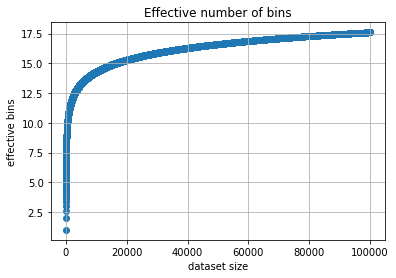

In [114]:
"""
Sturge's rule (kfold for regression)
------------------------------------
for regression, targets needs to be converted
to bins

- if large dataset >10k (or) >100k
    + use 10 or 20 bin
- if small dataset <10k 
    + use 1+lg(size_of_dataset) 
"""

def strurge(X):
  return 1 + np.log2(X)

lst = np.arange(1, 100000)
bins = strurge(lst)
plt.scatter(lst, bins)

plt.title('Effective number of bins')
plt.xlabel('dataset size')
plt.ylabel('effective bins')
plt.grid()
plt.show()